In [2]:
import sys
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os
import math

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import statsmodels.api as sm

In [3]:
#Data on Microsoft
Msft_final = pd.read_csv('MicrosoftFinalData.csv', delimiter=',')
Msft_final.dataframeName = 'MicrosoftFinalData.csv'
Msft_news = pd.read_csv('MicrosoftNewsStock.csv', delimiter=',')
Msft_news.dataframeName = 'MicrosoftNewsStock.csv'

#Data on S&P500
SNP500_data = pd.read_csv('^GSPC.csv', delimiter=',')
SNP500_data.dataframeName = '^GSPC.csv'

#Data on DJI
DJI_data = pd.read_csv('^DJI.csv', delimiter=',')
DJI_data.dataframeName = '^DJI.csv'
DJI_news = pd.read_csv('Combined_News_DJIA.csv', delimiter=',')
DJI_news.dataframeName = 'Combined_News_DJIA.csv'

#Data on Apple
Appl_final = pd.read_csv('AppleFinalData.csv', delimiter=',')
Appl_final.dataframeName = 'AppleFinalData.csv'
Appl_news = pd.read_csv('AppleNewsStock.csv', delimiter=',')
Appl_news.dataframeName = 'AppleNewsStock.csv'

DJI_data['Date'] = pd.to_datetime(DJI_data['Date'])
DJI_data.set_index('Date',inplace=True)
SNP500_data['Date'] = pd.to_datetime(SNP500_data['Date'])
SNP500_data.set_index('Date',inplace=True)
DJI_news

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [6]:
def if_news(column):
    if column == 0:
        return 0
    else:
        return 1

In [51]:
#Msft_final['returns']=Msft_final['Close'].pct_change() 
Msft_final['returns']= np.log(Msft_final['Close'].shift(-1)/Msft_final['Close']) #log-returns
Msft_final['flows'] = (Msft_news['Volume']-Msft_news['Volume'].shift(1)) # Flows
Msft_final['if_news'] = Msft_final['compound'].apply(if_news)
Msft_final['50_mov_average'] = Msft_final['returns'].rolling(window=50).mean().shift(-1)#.cumsum()
Msft_final['250_mov_average'] = Msft_final['returns'].rolling(window=250).mean().shift(-1)#.cumsum()






df_weekly_Msft = Msft_final[['Date','returns','flows','50_mov_average','250_mov_average', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Msft['Date'] = pd.to_datetime(df_weekly_Msft['Date'])
df_weekly_Msft.set_index('Date',inplace=True)
df_weekly_Msft = df_weekly_Msft[1:-1]

#Appl_final['returns']=Appl_final['Close'].pct_change() 
Appl_final['returns']= np.log(Appl_final['Close'].shift(-1)/Appl_final['Close']) #log-returns
Appl_final['flows'] = (Appl_news['Volume']-Appl_news['Volume'].shift(1)) # flows
Appl_final['if_news'] = Appl_final['compound'].apply(if_news)
Appl_final['50_mov_average'] = Appl_final['returns'].rolling(window=50).mean().shift(-1)#.cumsum
Appl_final['250_mov_average'] = Appl_final['returns'].rolling(window=250).mean().shift(-1)#.cumsum()


df_weekly_Appl = Appl_final[['Date','returns','flows','50_mov_average','250_mov_average','compound', 'neg', 'pos', 'if_news']]
df_weekly_Appl['Date'] = pd.to_datetime(df_weekly_Appl['Date'])
df_weekly_Appl.set_index('Date',inplace=True)
df_weekly_Appl = df_weekly_Appl[1:-1]

SNP500_data['returns'] = np.log(SNP500_data['Close']/SNP500_data['Close'].shift(1)) #log-returns
SNP500_data['cum_returns']=SNP500_data['returns'].cumsum()

#SNP500_data['Date'] = pd.to_datetime(SNP500_data['Date'])
#SNP500_data.set_index('Date',inplace=True)

DJI_data['returns'] =  np.log(DJI_data['Close']/DJI_data['Close'].shift(1)) #log-returns
DJI_data['cum_returns']=DJI_data['returns'].cumsum()
#DJI_data['Date'] = pd.to_datetime(DJI_data['Date'])
#DJI_data.set_index('Date',inplace=True)
#

#DJI_news['Date'] = pd.to_datetime(DJI_news['Date'])
Appl_final

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Open,High,Low,Close,Adj Close,compound,neg,neu,pos,returns,flows,if_news,50_mov_average,250_mov_average,Volume,Cap,Cum rets
0,2006-12-01,13.1143,13.1900,12.8714,91.32,13.0457,0.7707,0.032,0.905,0.063,-0.002193,NaN,1,NaN,NaN,198769900,NaN,NaN
1,2006-12-04,13.1257,13.1500,12.9286,91.12,13.0171,0.8720,0.011,0.904,0.085,0.001645,-21385700.0,1,NaN,NaN,177384200,-0.109545,-0.109545
2,2006-12-05,13.0929,13.1900,12.9814,91.27,13.0386,0.0000,0.000,0.000,0.000,-0.015903,-11674600.0,0,NaN,NaN,165709600,-0.064277,-0.173822
3,2006-12-06,12.9486,13.0557,12.8100,89.83,12.8329,0.6858,0.029,0.878,0.093,-0.031551,-6163500.0,1,NaN,NaN,159546100,-0.052385,-0.226207
4,2006-12-07,12.8614,12.9286,12.4143,87.04,12.4343,-0.6712,0.091,0.869,0.040,0.013919,91660800.0,1,NaN,NaN,251206900,0.525608,0.299400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2016-11-23,111.3600,111.5100,110.3300,111.23,111.2300,0.0000,0.000,0.000,0.000,0.005022,1460900.0,0,-0.000592,-0.000202,27426400,0.050878,133.650834
2513,2016-11-25,111.1300,111.8700,110.9500,111.79,111.7900,-0.8990,0.115,0.885,0.000,-0.001970,-15950500.0,1,-0.000377,-0.000169,11475900,-0.579468,133.071366
2514,2016-11-28,111.4300,112.4700,111.3900,111.57,111.5700,0.0000,0.000,0.000,0.000,-0.000986,15718100.0,0,-0.000544,-0.000166,27194000,1.364998,134.436364
2515,2016-11-29,110.7800,112.0300,110.0700,111.46,111.4600,0.0000,0.000,0.000,0.000,-0.008469,1334800.0,0,NaN,NaN,28528800,0.048050,134.484414


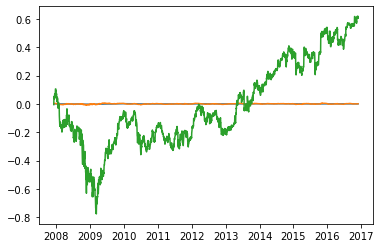

In [39]:
plt.figure()
plt.plot(df_weekly_Msft['250_mov_average'][250:])
plt.plot(df_weekly_Msft['50_mov_average'][250:])
plt.plot(df_weekly_Msft['returns'][250:].cumsum())
plt.show()

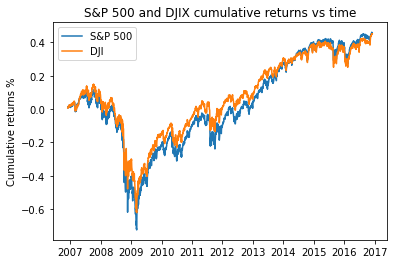

In [40]:
plt.figure()
plt.title('S&P 500 and DJIX cumulative returns vs time')
plt.ylabel('Cumulative returns %')
plt.plot(SNP500_data['cum_returns'],label = 'S&P 500')
plt.plot(DJI_data['cum_returns'],label = 'DJI')
plt.legend()
plt.show()

### Checking for class imbalance

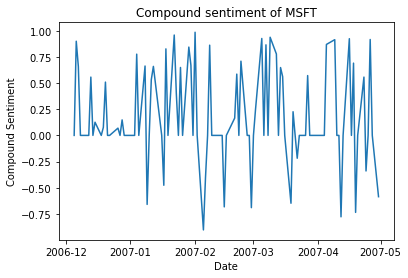

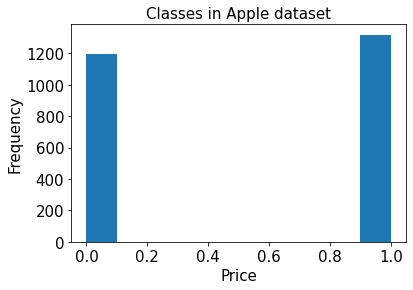

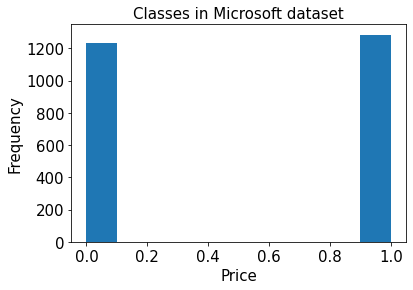

In [41]:
plt.figure(1)
plt.plot(df_weekly_Msft["compound"][1:100])
plt.xlabel("Date")
plt.ylabel("Compound Sentiment")
plt.title("Compound sentiment of MSFT")
plt.show()

df_weekly_Appl['class count'] = np.where(df_weekly_Appl['returns']>= 0, 1 , 0)
df_weekly_Msft['class count'] = np.where(df_weekly_Msft['returns']>= 0, 1 , 0)

plt.hist(df_weekly_Appl['class count'])
plt.title('Classes in Apple dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.hist(df_weekly_Msft['class count'])
plt.title('Classes in Microsoft dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [42]:
def sentiment_value(df):
    analyser = SentimentIntensityAnalyzer()      
    if type(df)== str:
        result = analyser.polarity_scores(df)

    else:
        result = analyser.polarity_scores('')
    score = result['compound']
    return score

def sentiment_dataframe(df,top_k_headlines):
    
    headers = (df.columns.values)[2:top_k_headlines+2]
    matrix = np.zeros([len(df),len(headers)])
    
    for k in range(len(headers)):
        for i in range(len(df)):
            print(i)
            matrix[i][k] = sentiment_value(df.iloc[i][k+2])
  
    dff = pd.DataFrame()
    dff = pd.DataFrame(columns = headers)
    
    j = 0
    for col in dff.columns:
        dff.loc[:, col] = matrix[:,j]
        j += 1
    dff['Date'] = df['Date']
    
    dff['Date'] = pd.to_datetime(dff['Date'])
    dff.set_index('Date',inplace=True)
    
    return dff

In [43]:
DJI_news_compound_scores = sentiment_dataframe(DJI_news,25)
DJI_news_compound_scores

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993


718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967


610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859


667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916


617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866


807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
104

770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015


785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027


735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984


626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875


733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982


614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863


501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750


439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688


780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023


729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978


968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
11

875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099


1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453


1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894


1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944


1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820


1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882


,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,...,0.0000,0.0000,0.2086,0.2023,0.0258,-0.7579,-0.6249,-0.2755,-0.8519,0.4019
2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,-0.3400,...,0.0000,0.0000,-0.6597,0.0000,0.0000,-0.8020,0.0000,-0.3182,-0.1832,0.0000
2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,...,0.0000,0.0000,0.0772,-0.5994,-0.5859,0.0000,0.5267,0.3818,0.0000,0.0000
2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,0.0000,...,0.0000,0.0000,0.0000,-0.5423,-0.0258,-0.2960,0.4939,-0.5719,-0.4215,-0.3400
2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,...,-0.6249,0.0000,0.0000,0.0000,0.0000,-0.4404,-0.5994,0.1779,-0.6908,0.7096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.2263,0.2732,-0.6369,-0.1027,0.6369,-0.5423,-0.7096,-0.5719,-0.5859,0.0000,...,-0.5994,0.8442,-0.5994,-0.0772,0.3182,0.1724,-0.1027,-0.6249,0.2500,0.1280
2016-06-28,0.8316,-0.4588,0.4939,0.3182,-0.7717,-0.7351,0.0000,0.2960,-0.2732,0.0000,...,0.5859,-0.6124,-0.0258,0.2732,0.2263,0.0000,0.6369,0.0000,-0.7184,-0.9349
2016-06-29,0.0000,-0.6808,0.7783,-0.7430,-0.4404,0.0000,-0.8020,0.2960,0.5719,-0.1779,...,0.5994,0.0000,-0.7430,-0.8807,-0.2263,-0.9211,-0.8402,0.2023,0.0000,0.0000


In [50]:
dataset_start = '2008-08-08'
dataset_end = '2016-07-02'

df_Msft_trim = df_weekly_Msft[(dataset_start <= df_weekly_Msft.index) & (df_weekly_Msft.index < dataset_end)]
df_Appl_trim = df_weekly_Appl[(dataset_start <= df_weekly_Appl.index) & (df_weekly_Appl.index < dataset_end)]
df_SNP500_trim = SNP500_data[(dataset_start <= SNP500_data.index) & (SNP500_data.index < dataset_end)]
df_DJI_trim = DJI_data[(dataset_start <= DJI_data.index) & (DJI_data.index < dataset_end)]
df_Msft_trim

,returns,flows,50_mov_average,250_mov_average,compound,neg,pos,if_news,class count
Date,,,,,,,,,
2008-08-08,-0.008210,-1751700.0,0.000229,0.000003,0.0000,0.000,0.000,0,0
2008-08-11,0.007854,-12070300.0,0.000435,0.000014,0.0000,0.000,0.000,0,1
2008-08-12,-0.007496,-5930800.0,0.000267,-0.000048,0.2023,0.000,0.057,1,0
2008-08-13,0.000000,-11647800.0,-0.000349,-0.000064,-0.8074,0.276,0.077,1,1
2008-08-14,-0.003589,-1432900.0,0.000145,-0.000055,0.0000,0.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...
2016-06-27,0.020640,-83286700.0,-0.002191,0.000518,0.8360,0.000,0.268,1,1
2016-06-28,0.022005,-12075600.0,-0.001657,0.000569,0.0000,0.000,0.000,0,1
2016-06-29,0.012388,-6836700.0,-0.001729,0.000576,-0.2732,0.060,0.059,1,1


In [49]:
Dataset_final = DJI_news_compound_scores
Dataset_final['Apple compound'] = df_Appl_trim['compound']
Dataset_final['Msft compound'] = df_Msft_trim['compound']
Dataset_final['DJI returns'] = df_DJI_trim['returns']
Dataset_final['S&P 500 returns'] = df_SNP500_trim['returns']
Dataset_final['Apple returns'] = df_Appl_trim['returns']
Dataset_final['Apple 50_m_avg']= df_Appl_trim['50_mov_average']
Dataset_final['Apple 250_m_avg']= df_Appl_trim['250_mov_average']
Dataset_final['Apple Label'] = df_Appl_trim['if_news']
Dataset_final['Apple flows'] = df_Appl_trim['flows']
Dataset_final['Microsoft returns'] = df_Msft_trim['returns']
Dataset_final['Microsoft 50_m_avg']= df_Msft_trim['50_mov_average']
Dataset_final['Microsoft 250_m_avg']= df_Msft_trim['250_mov_average']
Dataset_final['Microsoft Label'] = df_Msft_trim['if_news']
Dataset_final['Microsoft flows'] = df_Msft_trim['flows']
Dataset_final.to_csv('Dataset_final_v2.csv')
df_weekly_Appl.to_csv('Benchmark_Apple.csv')
df_weekly_Msft.to_csv('Benchmark_Msft.csv')
Dataset_final

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Apple returns,Apple 50_m_avg,Apple 250_m_avg,Apple Label,Apple flows,Microsoft returns,Microsoft 50_m_avg,Microsoft 250_m_avg,Microsoft Label,Microsoft flows
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,...,0.023375,-0.001033,0.001552,1,10406200.0,-0.008210,0.000229,0.000003,0,-1751700.0
2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,-0.3400,...,0.018100,-0.000666,0.001706,1,44326800.0,0.007854,0.000435,0.000014,0,-12070300.0
2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,...,0.014437,-0.000644,0.001539,1,-13756400.0,-0.007496,0.000267,-0.000048,1,-5930800.0
2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,0.0000,...,0.000112,-0.001500,0.001453,0,1516900.0,0.000000,-0.000349,-0.000064,1,-11647800.0
2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,...,-0.020166,-0.001136,0.001273,1,-32761400.0,-0.003589,0.000145,-0.000055,0,-1432900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.2263,0.2732,-0.6369,-0.1027,0.6369,-0.5423,-0.7096,-0.5719,-0.5859,0.0000,...,0.016700,-0.002489,-0.001169,1,-29821800.0,0.020640,-0.002191,0.000518,1,-83286700.0
2016-06-28,0.8316,-0.4588,0.4939,0.3182,-0.7717,-0.7351,0.0000,0.2960,-0.2732,0.0000,...,0.008618,-0.002277,-0.001104,1,-5044700.0,0.022005,-0.001657,0.000569,0,-12075600.0
2016-06-29,0.0000,-0.6808,0.7783,-0.7430,-0.4404,0.0000,-0.8020,0.2960,0.5719,-0.1779,...,0.012632,-0.001999,-0.001082,1,-3913900.0,0.012388,-0.001729,0.000576,1,-6836700.0


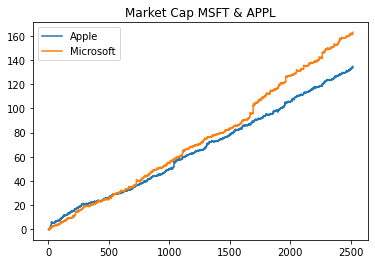

In [9]:
Appl_final['Volume'] = Appl_news['Volume']
Appl_final['Cap'] = (Appl_final['Volume']*Appl_final['Close']).pct_change()
Appl_final['Cum rets'] = Appl_final['Cap'].cumsum()

Msft_final['Volume'] = Msft_news['Volume']
Msft_final['Cap'] = (Msft_final['Volume']*Msft_final['Close']).pct_change()
Msft_final['Cum rets'] = Msft_final['Cap'].cumsum()

plt.figure()
plt.title('Market Cap MSFT & APPL')
plt.plot(Appl_final['Cum rets'],label = 'Apple')
plt.plot(Msft_final['Cum rets'], label = 'Microsoft')
plt.legend()
plt.show()